In [2]:
import numpy as np
import pandas as pd
import glob
from pprint import pprint
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline




pd.set_option('display.max_columns',None)

#Import Data
path = r'/homes/chh30/ECS784-PROJECT/sourcedata'
filenames = glob.glob(path+"/*.csv")

frame = pd.DataFrame

list = []

for file_ in filenames:
     df = pd.read_csv(file_,index_col=None,encoding = "ISO-8859-1",header=0)
     list.append(df)

frame = pd.concat(list,ignore_index=True,sort=False)

frame.head()
print(frame.shape)

(10216388, 15)


In [3]:
# Clean Data


##Drop records with null value
frame.dropna(axis=0, subset=["Rental Id",
                             "Bike Id",
                             "Start Date",
                             "StartStation Id",
                             "StartStation Name",
                             "End Date",
                             "EndStation Id",
                             "EndStation Name",
                             "Duration"], inplace=True)


## Extra drop for duplicates
frame.drop_duplicates(inplace=True)



## Formatting column
frame["Bike Id"] = frame["Bike Id"].astype(int)
frame["Rental Id"] = frame["Rental Id"].astype(int)
frame["EndStation Id"] = frame["EndStation Id"].astype(int)
frame["StartStation Id"] = frame["StartStation Id"].astype(int)
frame["EndStation Id"] = frame["EndStation Id"].astype(int)
frame["Duration"] = frame["Duration"].astype(int)

## Clean up data which StartStation Id = EndStation Id
frame = frame[frame["StartStation Id"] != frame["EndStation Id"]]


## Grab the column we need
frame = frame.loc[:,('Start Date',
                           'StartStation Id',
                           'StartStation Name',
                           'End Date',
                           'EndStation Id',
                           'EndStation Name',
                           'Duration')]


## Change 'Start Date', 'End Date' Data Type as datetime
frame['Start Date'] = pd.to_datetime(frame['Start Date'],format='%d/%m/%Y %H:%M',dayfirst=True)
frame['End Date'] = pd.to_datetime(frame['End Date'],format='%d/%m/%Y %H:%M',dayfirst=True)


## Grab data between 2016/01/01 00:00:00 to 2016/12/31 23:59:59
begin = pd.Timestamp('2016-01-01 00:00:00')
end = pd.Timestamp('2016-12-31 23:59:59')
mask=(frame['Start Date'] >= begin)&(frame['Start Date'] <= end)
frame.loc[mask]


frame.describe()

,StartStation Id,EndStation Id,Duration
count,9.533099e+06,9.533099e+06,9.533099e+06
mean,3.505212e+02,3.474602e+02,1.187304e+03
std,2.309940e+02,2.307544e+02,6.620339e+03
min,1.000000e+00,1.000000e+00,-3.540000e+03
25%,1.540000e+02,1.540000e+02,4.800000e+02
50%,3.160000e+02,3.100000e+02,7.800000e+02
75%,5.410000e+02,5.400000e+02,1.260000e+03
max,8.200000e+02,8.200000e+02,2.674020e+06


In [4]:
# Missing data checking

missing_data = frame.isnull()

for column in missing_data.columns.values.tolist():
    print(column)
    print(missing_data[column].value_counts())
    print("")

Start Date
False    9533099
Name: Start Date, dtype: int64

StartStation Id
False    9533099
Name: StartStation Id, dtype: int64

StartStation Name
False    9533099
Name: StartStation Name, dtype: int64

End Date
False    9533099
Name: End Date, dtype: int64

EndStation Id
False    9533099
Name: EndStation Id, dtype: int64

EndStation Name
False    9533099
Name: EndStation Name, dtype: int64

Duration
False    9533099
Name: Duration, dtype: int64



In [5]:
frame.tail(10)

,Start Date,StartStation Id,StartStation Name,End Date,EndStation Id,EndStation Name,Duration
10216377,2016-05-17 23:56:00,407,"Speakers' Corner 1, Hyde Park",2016-05-18 00:19:00,320,"Queen Mother Sports Centre, Victoria",1380
10216378,2016-05-17 23:56:00,331,"Bunhill Row, Moorgate",2016-05-18 00:04:00,544,"Percival Street, Finsbury",480
10216379,2016-05-17 23:56:00,4,"St. Chad's Street, King's Cross",2016-05-18 00:04:00,364,"Alfred Place, Bloomsbury",480
10216380,2016-05-17 23:57:00,815,"Lambeth Palace Road, Waterloo",2016-05-18 00:03:00,317,"Dickens Square, Borough",360
10216381,2016-05-17 23:57:00,670,"Ashley Crescent, Battersea",2016-05-18 00:05:00,744,"Ingrave Street, Clapham Junction",480
10216382,2016-05-17 23:57:00,486,"Granby Street, Shoreditch",2016-05-18 00:20:00,520,"Bancroft Road, Bethnal Green",1380
10216383,2016-05-17 23:57:00,206,"New Road 1 , Whitechapel",2016-05-18 00:02:00,202,"Leman Street, Aldgate",300
10216384,2016-05-17 23:57:00,206,"New Road 1 , Whitechapel",2016-05-18 00:02:00,202,"Leman Street, Aldgate",300
10216385,2016-05-17 23:57:00,188,"Nutford Place, Marylebone",2016-05-18 00:04:00,210,"Hinde Street, Marylebone",420
10216387,2016-05-17 23:59:00,666,"Olympia Way, Olympia",2016-05-18 00:06:00,626,"Normand Park, West Kensington",420


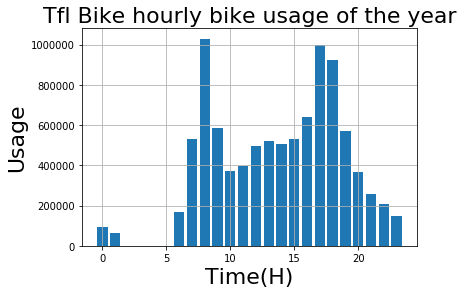

In [13]:
# Hourly usage analysis

HourlyData = frame.loc[:,('Start Date',
                           'StartStation Id',
                           'StartStation Name')]

HourlyData['Hour'] = HourlyData['Start Date'].map(lambda x: x.hour)
dfh = HourlyData.groupby(['Hour']).size().reset_index(name='HourlyRental').nlargest(20,columns='HourlyRental').tail(20).sort_values(by='Hour',ascending=True)


plt.title("Tfl Bike hourly bike usage of the year", fontsize = 22)
plt.xlabel('Time(H)', fontsize = 22)
plt.ylabel('Usage', fontsize = 22)
plt.grid(True)
plt.tick_params(labelsize = 10)

plt.bar(dfh['Hour'],dfh['HourlyRental'])

plt.show()


In [ ]:
# See which journey between two station has the most transaction record
journeyCnt = frame.groupby(['StartStation Name','StartStation Id','EndStation Name','EndStation Id']).size().reset_index(name='Rental_Counts').nlargest(5,columns='Rental_Counts').tail(5)
journeyCnt

In [ ]:
# Get journey data between Black Lion Gate and Palace Gate
journeyData = frame[(frame['StartStation Id']==307)&(frame['EndStation Id']==404)]


# Spilt Year,Month, Hour from Start Date
journeyData['Year']= journeyData['Start Date'].map(lambda x:x.year)
journeyData['Month'] = journeyData['Start Date'].map(lambda x: x.month)
journeyData['Hour'] = journeyData['Start Date'].map(lambda x: x.hour)

# Cleaning the transaction between 7am to 21pm
hourmask=(journeyData['Hour']>=7)&(journeyData['Hour']<=21)
journeyData.loc[hourmask]

# Grab needed column
df1 = journeyData.loc[:,(  'Start Date',
                           'Year',
                           'Month',
                           'Hour',
                           'Duration')]
df1.tail(10)


In [ ]:
dfRentalCnt = df1.groupby(['Year','Month','Hour']).size().reset_index(name='HourlyCount')
dfRentalCnt['HourlyCount'] = dfRentalCnt['HourlyCount']/100

for i in range(12):
    x = i+1
    dfCSV = dfRentalCnt.loc[dfRentalCnt['Month']==x,('Hour','HourlyCount')]
    Path = r'/homes/chh30/ECS784-PROJECT/Export_Data/WeekdayRental'+str(x)+'.csv'
    dfCSV.to_csv(Path,index=False)
    
dfRentalCnt.head(12)

In [ ]:
import calendar as cl
dfDuration = df1
dfDuration['monthrange'] = (dfDuration['Start Date'].map(lambda x: cl.monthrange(x.year,x.month)[1]))
dfDuration['Duration'] = dfDuration['Duration']/dfDuration['monthrange']
dfDuration = dfDuration.groupby(['Year','Month','Hour'])['Duration'].agg(['sum'])
dfDuration.tail(10)
pathDuration = r'/homes/chh30/ECS784-PROJECT/Export_Data/Duration.csv'
dfDuration.to_csv(pathDuration,index=False)

dfDuration.tail(10)